# 1. Introduction

In this case study, the challenge is to build prediction models to predict the expected total amount of sales for each of the customers. The calibration period is 9 months long (9/1/2016 - 5/31/2017) and the holdout period is 3 months (6/1/2017 - 8/31/2017).

This notebook is an exploratory data analysis to first have a look at the data, do some visulizations and understand the relations between different variables. In the end, we made our first attempt implementing a BG/NBD and Gamma-Gamma model to predict the sales in the future 3 months.

# 2. Load packages and data

In [3]:
import os
os.chdir("C://Users/Think/Desktop/case")
%matplotlib inline
import numpy as np 
import pandas as pd 
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import time
from lifetimes.utils import summary_data_from_transaction_data

In [4]:
customer_trans_log=pd.read_csv("customer_trans_log.csv")
customer_info=pd.read_csv("customer_info.csv")

Let's first take a glimpse of the data.

In [26]:
print('We have {} rows and {} columns in customer_trans_log.'.format(customer_trans_log.shape[0], customer_trans_log.shape[1]))
print('We do not need to worry about missing values.') if customer_trans_log.count().min() == customer_trans_log.shape[0] else print('oops')
print('All the customers in customer_info have transaction event(s)') if customer_trans_log.customer_id.nunique() == customer_info.shape[0] else print('oops')
customer_trans_log.head()

We have 115345 rows and 3 columns in customer_trans_log.
We do not need to worry about missing values.
All the customers in customer_info have transaction event(s)


,customer_id,date,sales
0,1,2016-09-01,62.79
1,10,2016-09-01,29.04
2,100,2016-09-01,38.02
3,1000,2016-09-01,13.42
4,10000,2016-09-01,34.89


In [20]:
print('We have {} rows and {} columns in customer_info.'.format(customer_info.shape[0], customer_info.shape[1]))
print('customer id is unique.') if customer_info.customer_id.nunique() == customer_info.shape[0] else print('oops')
print('We do not need to worry about missing values.') if customer_info.count().min() == customer_info.shape[0] else print('oops')
customer_info.head()

We have 20000 rows and 8 columns in customer_info.
customer id is unique.
We do not need to worry about missing values.


,customer_id,First Payment Type,Age,Gender,Loyalty Program,Acquisition Channel,First Department,Shared Email
0,1,Credit Card,30 - 40,Male,0,Referral,Outdoors,1
1,10,Credit Card,70 - 80,Female,1,Organic Search,Books,1
2,100,Credit Card,40 - 50,Female,1,Unknown,Toys,0
3,1000,Check,30 - 40,Male,1,Paid Search,Baby,1
4,10000,Credit Card,50 - 60,Female,1,Facebook,Toys,1


# 3. Data understanding -- transaction log data

## 3.1 Generate RFM features

We are first interested in looking into the transaction summary of each individual -- What is the average transaction value? How many orders does each customer have? How many customers are still active in the last month? ... As it might imply, we are going to explore the customers' RFM features.

Luckily I found a python package called **lifetime** to do the RFM transformation for me. For an explanation of RFM features, I would cite the description on **lifetime**'s offical documentation [2]:

- `frequency` represents the number of *repeat* purchases the customer has made. This means that it's one less than the total number of purchases. 
- `T` represents the age of the customer in whatever time units chosen. This is equal to the duration between a customer's first purchase and the end of the period under study.
- `recency` represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer's first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

However, the RFM transformation function in **lifetime** doesn't take care of the monetary value (or maybe I haven't found that part). So I will calculate the monetary value (average order value) by myself.

In [34]:
#prepare dataframe for LIFETIME to convert
log1=customer_trans_log.iloc[:,0:2].rename(columns={'customer_id':'id'})
log1.head()

,id,date
0,1,2016-09-01
1,10,2016-09-01
2,100,2016-09-01
3,1000,2016-09-01
4,10000,2016-09-01


In [55]:
#Get the RFM features. Since it might take a while, we will also print out the running time.
time1=time.time()
summary = summary_data_from_transaction_data(log1, 'id', 'date', observation_period_end='2017-5-31')
time2=time.time()
diff=round(time2-time1)
print('took {} seconds'.format(diff))
print(summary.head())
print('All the customers were acquired on the first day') if summary['T'].nunique()==1 else print(' ')

took 46 seconds
    frequency  recency      T
id                           
1         1.0    202.0  272.0
2        29.0    254.0  272.0
3        11.0    265.0  272.0
4        23.0    265.0  272.0
5         2.0    256.0  272.0
All the customers were acquired on the first day


To explain the table, we take the customer with id 2 as an example. The second customer has 29 orders in the past 9 months(let's assume today is 5/31/2017) and the last order was placed on 2017-05-13 (2016-09-01 + 254 days).

In [91]:
#calculate the average order value for each customer
def calc_mean_sales(customer_id,customer_trans_log):
    log2=customer_trans_log[customer_trans_log['customer_id']==customer_id]
    return log2.mean()[1].item()
money=[]
time1=time.time()
for i in range(20000):
    m=calc_mean_sales(i+1,customer_trans_log)
    money.append(round(m,2))
time2=time.time()
diff=round(time2-time1)
print('took {} seconds'.format(diff))
summary_with_money_value=summary
summary_with_money_value['monetary_value']=money
print(summary_with_money_value.head())

took 56 seconds
    frequency  recency      T  monetary_value
id                                           
1         1.0    202.0  272.0           80.66
2        29.0    254.0  272.0           27.68
3        11.0    265.0  272.0           27.56
4        23.0    265.0  272.0           36.54
5         2.0    256.0  272.0           26.88


## 3.2 Analyze RFM features

Now we have finished generating the RFM features. Let's do some basic analysis!

In [92]:
summary_with_money_value.describe()

,frequency,recency,T,monetary_value
count,20000.000000,20000.000000,20000.0,20000.000000
mean,4.767250,70.760100,272.0,34.855688
std,9.617105,95.738889,0.0,28.800982
min,0.000000,0.000000,272.0,2.390000
25%,0.000000,0.000000,272.0,18.130000
50%,1.000000,13.000000,272.0,27.350000
75%,5.000000,128.000000,272.0,41.730000
max,142.000000,272.000000,272.0,500.000000


### 3.2.1 Histograms

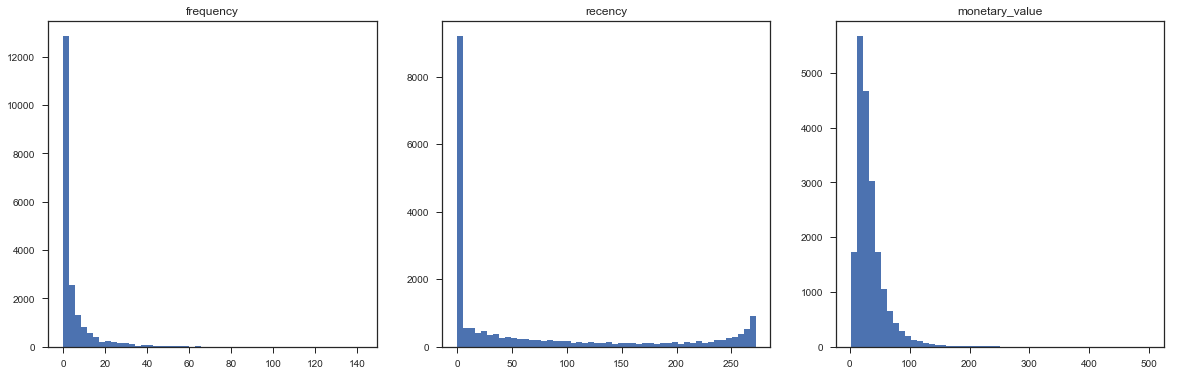

In [393]:
cols=['frequency','recency','monetary_value']
plt.figure(figsize=(20, 6))
for i in range(3):
    x=summary_with_money_value[cols[i]]
    plt.subplot(131+i)
    plt.hist(x,bins=50)
    title=cols[i]
    plt.title(title)
plt.show()

### 3.2.2 2-D and 3-D scatter plots

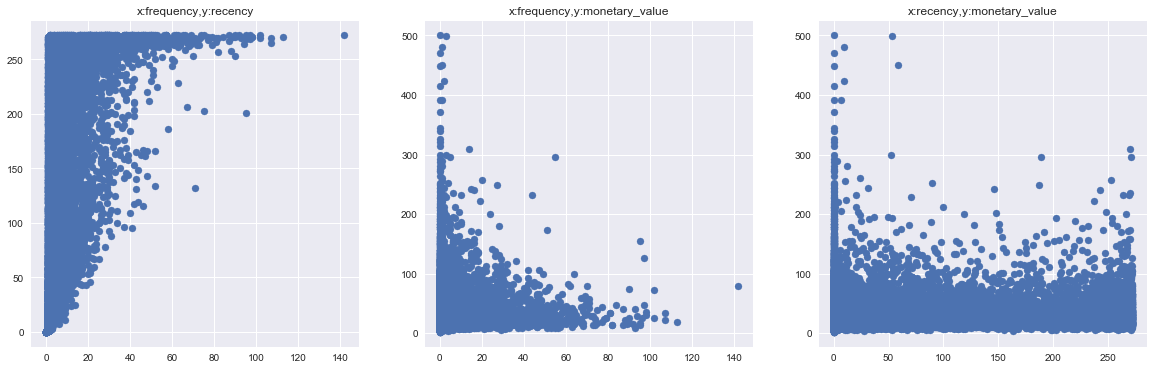

In [133]:
plt.figure(figsize=(20, 6))
index=[[0,1],[0,2],[1,2]]
cols=['frequency','recency','monetary_value']
for i in range(3):
    col1=cols[index[i][0]]
    col2=cols[index[i][1]]
    x=summary_with_money_value[col1]
    y=summary_with_money_value[col2]
    plt.subplot(131+i)
    plt.scatter(x,y)
    title='x:'+ col1+',y:'+col2
    plt.title(title)
plt.show()

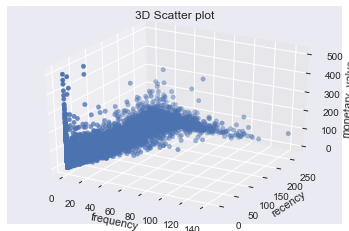

In [144]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(summary_with_money_value['frequency'],summary_with_money_value['recency'],summary_with_money_value['monetary_value'])
plt.title('3D Scatter plot')
ax.set_xlabel('frequency')
ax.set_ylabel('recency')
ax.set_zlabel('monetary_value')
plt.show()

From the summary table and graphs above, we can tell that most of the customers have fewer than 10 orders, never made a second purchase after the first one and on average spend less than 50 dollars on a single purchase. There are some outliers such as the one who made 142 purchases. Since in the end we need to predict the LTV for all the customers, I will keep the outliers here and I believe they won't affect the result much.

In plain words, only a few of the customers are highly valuble and loyal.

Let's quantify some of the findings we had above. ↓

In [385]:
pec1=round(len(summary_with_money_value[summary_with_money_value['frequency']>10])/len(summary_with_money_value)*100,2)
pec2=round(len(summary_with_money_value[summary_with_money_value['frequency']>30])/len(summary_with_money_value)*100,2)
pec3=round(len(summary_with_money_value[summary_with_money_value['frequency']>50])/len(summary_with_money_value)*100,2)
pec4=round(len(summary_with_money_value[summary_with_money_value['recency']<30])/len(summary_with_money_value)*100,2)
pec5=round(len(summary_with_money_value[summary_with_money_value['recency']>250])/len(summary_with_money_value)*100,2)
pec6=round(len(summary_with_money_value[summary_with_money_value['monetary_value']>50])/len(summary_with_money_value)*100,2)
pec7=round(len(summary_with_money_value[summary_with_money_value['monetary_value']>100])/len(summary_with_money_value)*100,2)
print('{}% customers have more than 10 orders'.format(pec1))
print('{}% customers have more than 30 orders'.format(pec2))
print('{}% customers have more than 50 orders'.format(pec3))
print('{}% customers dropped out after the first month'.format(pec4))
print('{}% customers are still active in the past month'.format(pec5))
print('{}% customers on average spend more than 50 dollars on a single purchase'.format(pec6))
print('{}% customers on average spend more than 100 dollars on a single purchase'.format(pec7))

13.73% customers have more than 10 orders
2.95% customers have more than 30 orders
0.79% customers have more than 50 orders
56.55% customers dropped out after the first month
10.55% customers are still active in the past month
17.27% customers on average spend more than 50 dollars on a single purchase
2.96% customers on average spend more than 100 dollars on a single purchase


# 4. Data understanding -- customer info data

Customer info data provides many variables that we can use when building our model. Let's take a look at all the features(col names) and what items each feature includes.

We have in total 7 catogorical features:

In [155]:
print(customer_info.columns)

Index(['customer_id', 'First Payment Type', 'Age', 'Gender', 'Loyalty Program',
       'Acquisition Channel', 'First Department', 'Shared Email'],
      dtype='object')


## 4.1 Pie charts

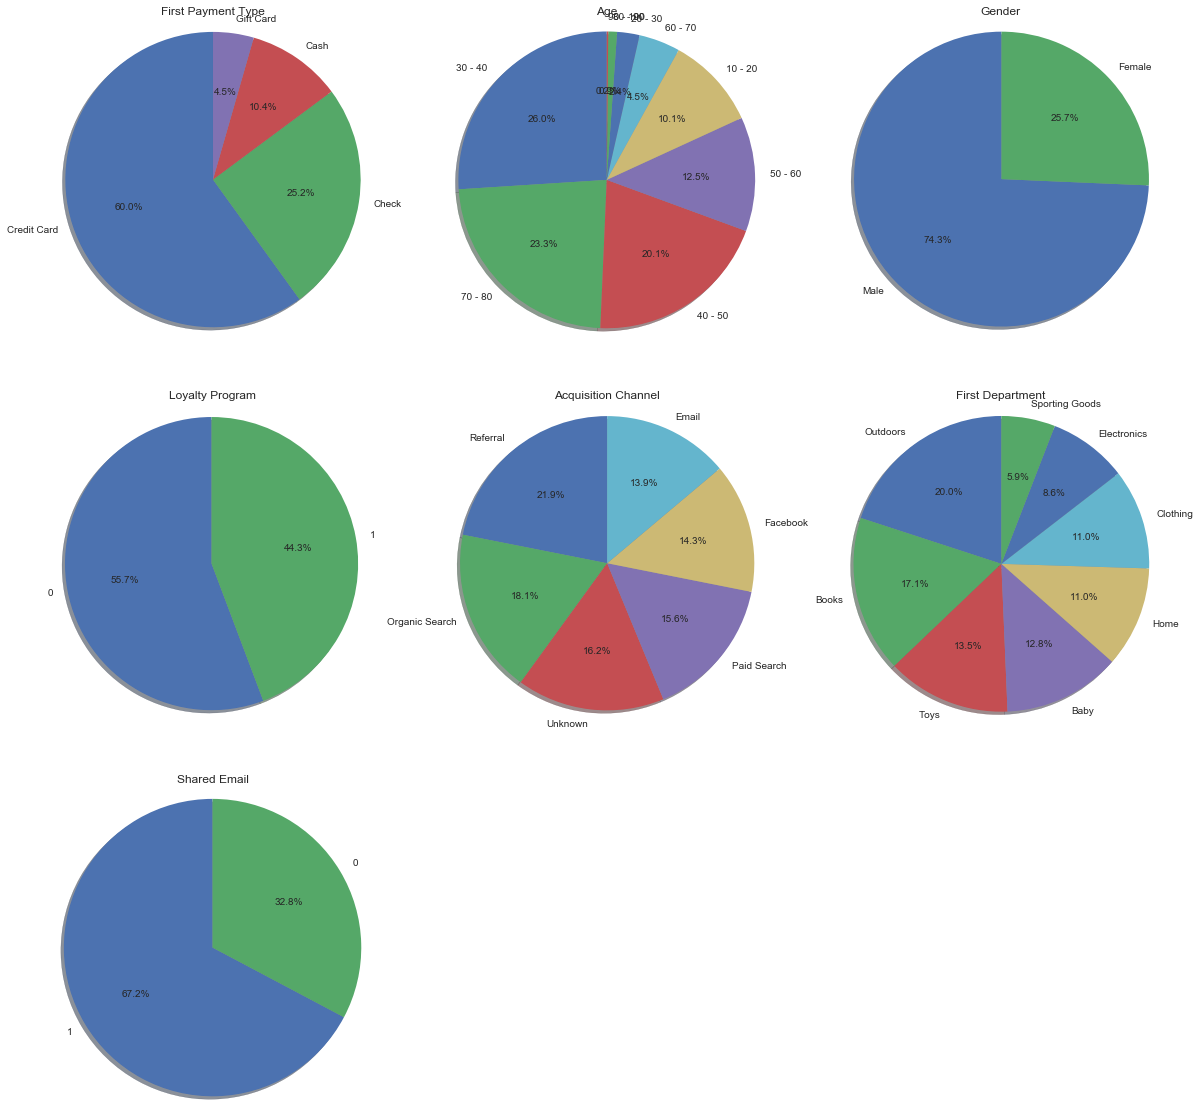

In [175]:
plt.figure(figsize=(20, 20))
columns=np.array(customer_info.columns)
for i in range(7):
    labels=customer_info[columns[i+1]].unique()
    sizes=np.array(customer_info[columns[i+1]].value_counts())
    plt.subplot(331+i)
    plt.pie(sizes,labels=labels,autopct='%1.1f%%', shadow=True, startangle=90)
    plt.title(columns[i+1])
    plt.axis('equal')
plt.show()

Since our final interest will be the customer lifetime value (total sales without discount in this case). I will calculate the total revenue each customer generated in the 9 month periods and do violinplot over these features. Since the frequency and monetary values are quite right-skewed, I will plot the **log(revenue)** against the dimensions in different features. Unfortunately I wasn't able to fugure out how to do subplot with seaborn. So the layout could be a little bit annoying.

In [288]:
#Calculate each customer's total revenue in the past 9 months
total_revenue_numbers=np.log(np.array((summary_with_money_value['frequency']+1)*summary_with_money_value['monetary_value']))
id_=np.arange(1,20001)
total_revenue=pd.DataFrame({'customer_id':id_,'log revenue':total_revenue_numbers})
#merge the datasets
customer_info_with_revenue=pd.merge(customer_info,total_revenue,on='customer_id',how='inner')

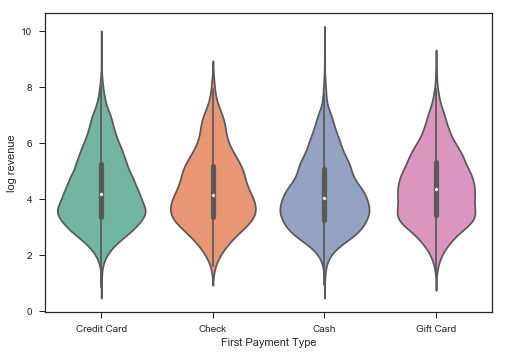

In [290]:
sns.violinplot(x=columns[1], y="log revenue",data=customer_info_with_revenue, palette="Set2")

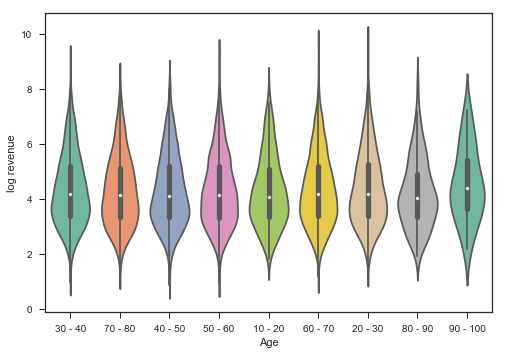

In [291]:
sns.violinplot(x=columns[2], y="log revenue",data=customer_info_with_revenue, palette="Set2")

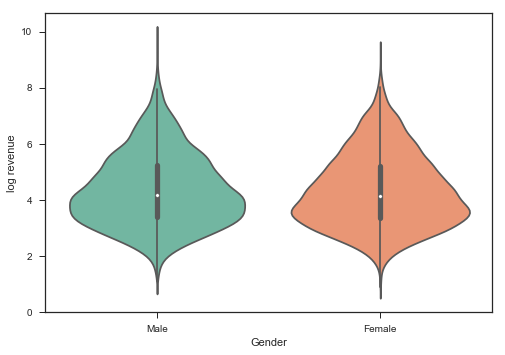

In [292]:
sns.violinplot(x=columns[3], y="log revenue",data=customer_info_with_revenue, palette="Set2")

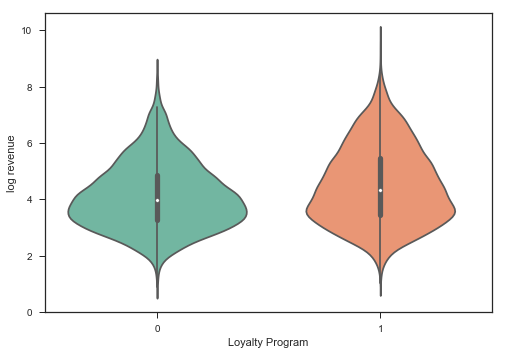

In [293]:
sns.violinplot(x=columns[4], y="log revenue",data=customer_info_with_revenue, palette="Set2")

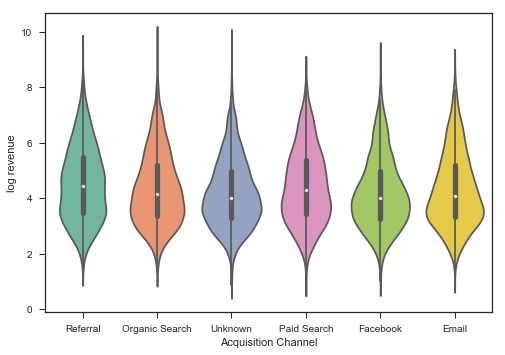

In [294]:
sns.violinplot(x=columns[5], y="log revenue",data=customer_info_with_revenue, palette="Set2")

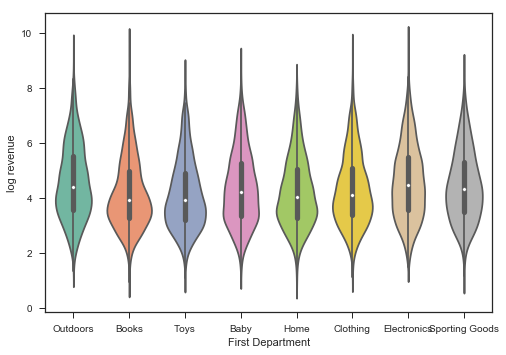

In [295]:
sns.violinplot(x=columns[6], y="log revenue",data=customer_info_with_revenue, palette="Set2")

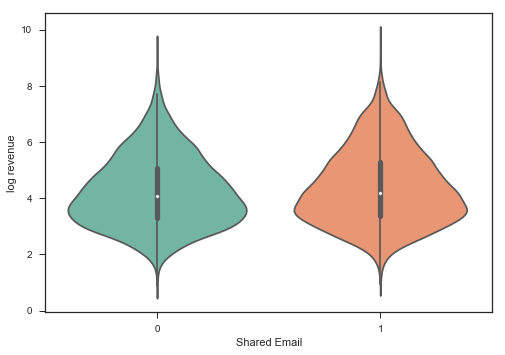

In [296]:
sns.violinplot(x=columns[7], y="log revenue",data=customer_info_with_revenue, palette="Set2")

From the violinsplots above, we can see some of the variables that can have great impact on the total revenues generated by a certain customer, such as loyalty program, acquisition channel and first department.

# 5. Our first trial -- a BG/NBD and Gamma-Gamma model

One classic way to estimate custoemr lifetime value is to use the Bayesian hierarchical model. The basic logic is to estimate the expected future frequency and average order value seperately and then multiply these two numbers (in our case) to get the total revenue generated by a customer in the next period. 

To calculate the expected future frequency, there are three models that are usually adopted: Pareto/NBD model, BG/NBD model and BG/BB model. Here we will only try BG(beta-geometric)/NBD model since we would love to spend more time exploring other advanced models. BG/NBD model is used to predict the number of non-contractual customers in the next period of time. It assumes: [3] 
- While active,the number of transactions made by a customer follows a Poisson process with transaction rate *λ* . 
- Heterogeneity in *λ* follows a gamma distribution.
- After any transaction, a customer becomes inactive with probability *p*. The point at which the customer "drops out" is distrubuted across transactions according to a geometric distribution.
- Heterogeneity in *p* follows a beta distribution.
- The transaction rate *λ* and the dropout probability p vary independently across customers.


To predict how much a customer will spend on each transaction, we use the Gamma-Gamma model. It assumes: [4]
- The amounts customer i spends on transactions are i.i.d. gamma variables with shape parameter *p<sub>i</sub>* and scale parameter *v<sub>i</sub>*
- *p* is constant across customers, and *v<sub>i</sub>* is distributed across customers according to a gamma distribution with shape parameter *q* and scale parameter *γ* 

Luckily we can implement the whole process with **lifetime** package. Since the model assumes there is no relationship between the monetary value and the purchase frequency. We first check the Pearson correlation between the two vectors is low:

In [298]:
returning_customers_summary = summary_with_money_value[summary_with_money_value['frequency']>0]
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.006759
frequency,0.006759,1.000000


It's exciting to see that the correlation is close to 0.

Construct the BG/NBD model for predicting expected frequency:

In [305]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary_with_money_value['frequency'], summary_with_money_value['recency'], summary_with_money_value['T'])

<lifetimes.BetaGeoFitter: fitted with 20000 subjects, a: 0.63, alpha: 5.28, b: 3.08, r: 0.23>

Fit the parameters for Gamma-Gamma model:

In [300]:
from lifetimes import GammaGammaFitter
time1=time.time()
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
time2=time.time()
diff=round(time2-time1)
print('took {} seconds'.format(diff))
print(ggf)

took 21 seconds
<lifetimes.GammaGammaFitter: fitted with 11467 subjects, p: 12.24, q: 3.66, v: 7.58>


We can now estimate the average transaction value:

In [307]:
pred_money=ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    )
print(pred_money.head(10))

id
1     72.473028
2     27.733349
3     27.701282
4     36.524109
5     27.661392
6     34.713554
7     34.844227
8     13.638946
9     34.844227
10    34.844227
dtype: float64


Let's compare the predicted average transaction value with the real numbers in the past 9 months for the first 100 customers:

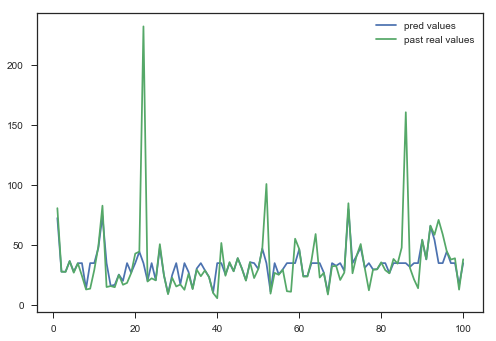

In [335]:
plt.plot(pred_money[:100],label='pred values')
plt.plot(summary_with_money_value['monetary_value'][:100],label='past real values')
plt.legend(loc='upper right')
plt.show()

We can see that the new monetary values are very similar to the old ones, while the new values are more moderate.

In [325]:
pred_total_revenue=ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    summary_with_money_value['frequency'],
    summary_with_money_value['recency'],
    summary_with_money_value['T'],
    summary_with_money_value['monetary_value'],
    time=3, # months
    discount_rate=0 # monthly discount rate ~ 12.7% annually
)
print(pred_total_revenue.head())

id
1     21.488676
2    211.423454
3     87.917287
4    242.447275
5     16.176129
Name: clv, dtype: float64


To see whether our prediction is reasonable, we compare the predicted values with the adjusted past real values (we divide the past 9-months total revenues by 3 to simulate the 3-months total revenues).

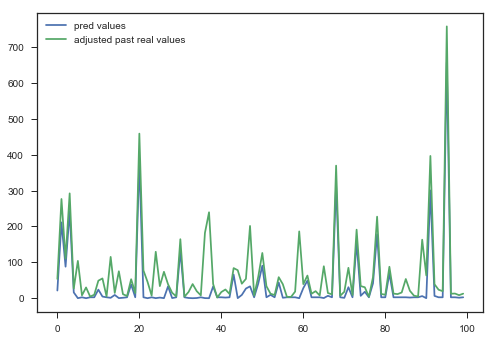

In [331]:
plt.plot(np.array(pred_total_revenue)[:100],label='pred values')
plt.plot(np.exp(total_revenue_numbers[:100])/3,label='adjusted past real values')
plt.legend(loc='upper left')
plt.show()

We can see that the predicted values are in general consistant with their past values, although they are more moderate. However, we can't tell if we are really doing a good job. But at least, it's reasonable and it reflects the past patterns.

The Bayesian hierarchical model approach only takes in the RFM features and we didn't use the customer_info table. I will utilize the features provided by that table later in our machine learing models.

In the end, let's save all the useful dataframes we generated in this notebook. 

In [371]:
preds_table=pd.read_csv("customer_preds.csv")
preds_value=pd.DataFrame({'customer_id':id_,'revenue':np.array(pred_total_revenue)})
def merge_table(format_table,target_table):
    time1=time.time()
    for i in range(len(preds_table)):
        index=format_table.iloc[i,0]
        value=np.array(target_table[target_table['customer_id']==index]['revenue'])
        format_table.iloc[i,1]=value
    time2=time.time()
    diff=round(time2-time1)
    print('took {} seconds'.format(diff))
    return(format_table)
submit_table=merge_table(preds_table,preds_value)

took 35 seconds


In [381]:
submit_table.to_csv("result_bayesian.csv",index=False)
summary_with_money_value.to_csv('RFM table.csv',index=False)
customer_info_with_revenue.to_csv('customer_info_with_revenue.csv',index=False)

# Reference

[1] https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367
<br>[2] http://lifetimes.readthedocs.io/en/latest/Quickstart.html#example-using-transactional-datasets
<br>[3] https://pdfs.semanticscholar.org/38de/78975e2040d25c86af75aca676791d8d6eee.pdf
<br>[4] http://www.seas.upenn.edu/~cse400/CSE400_2013_2014/reports/13_report.pdf